# Prepare RoboAdvisor Training Data

In [1]:
from pathlib import Path
from typing import List, Tuple, Union, Set
import glob

import pandas as pd
import numpy as np

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

from pyspark.sql.functions import col

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
print("sns-version: ", sns.__version__)

# there are issues when using sns scatterplot (replot) with matplotlib version 3.3.1, so we have to check if it is actual
print("matplotlib-version: ", matplotlib.__version__)

sns-version:  0.10.1
matplotlib-version:  3.3.2


In [2]:
trainingset_folder    = "D:/data_mt/09_training/"
stock_data_folder = trainingset_folder + "stocks/"
combine_data_folder = trainingset_folder + "combined/"

combined_data_file = trainingset_folder + "/all_combine_data_w_potential"

model_folder = "D:/data_mt/10_models/"
model_name   = "06_robo_advisor_predictor"

## 01_Tools

In [3]:
def load_additional_info_spark():
    return spark.read.csv(trainingset_folder + "company_info.csv", header=True, dateFormat="yyyy-MM-dd", inferSchema=True)

In [4]:
def load_additional_info() -> pd.DataFrame:
    return pd.read_csv(trainingset_folder + "company_info.csv", sep=',', encoding='utf-8', header=0)

In [5]:
import findspark
from pyspark.sql import SparkSession
def get_spark_session(appname = "default"):
    """
    Initialises a spark session. 
    Parameters:
    appname - default is "default"
    """
    findspark.init()
    return SparkSession.builder \
                        .appName(appname) \
                        .getOrCreate()

In [6]:
# init Spark
spark = get_spark_session() # Session anlegen
spark # display the moste important information of the session

## 02_Load Data

In [7]:
add_info_spark = load_additional_info_spark()

In [8]:
df_all = spark.read.parquet(combined_data_file)
df_all.count()

4365181

In [9]:
df_joined = df_all.join(add_info_spark, ["ticker"], "left")

In [10]:
add_info = load_additional_info()

## 03_Build Train and Testdata
"close_norm" is removed.
features for sectors and industries are added.

In [11]:
features = ['r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio', 'r_netProfitMargin', 'r_operatingMargin', 'r_netIncomeMargin', 
            'r_cashGenPowerRatio', 'r_extFinancingIndexRatio', 'r_returnOnEquity', 'r_returnOnAssets', 'r_assetsTurnoverRatio', 'r_dividendPayoutRatio', 
            'r_stockRepurchaseRatio', 'r_operatingCashFlowRatio', 'r_assetEfficiencyRatio', 'r_currentLiabCoverageRatio', 'r_longtermDeptCoverageRatio',
            
            'gr_revenue_n', 'gr_revenue_p', 'gr_grosspr_n', 'gr_grosspr_p', 'gr_opiincome_n', 'gr_opiincome_p', 'gr_netincome_n', 'gr_netincome_p', 
            'gr_earnings_n', 'gr_earnings_p', 'gr_equity_n', 'gr_equity_p', 'gr_asscur_n', 'gr_asscur_p', 'gr_assnoncur_n', 'gr_assnoncur_p', 
            'gr_liabcur_n', 'gr_liabcur_p', 'gr_liabnoncur_n', 'gr_liabnoncur_p', 'gr_cashfrominv_n', 'gr_cashfrominv_p', 
            'gr_cashfromfin_n', 'gr_cashfromfin_p', 'gr_cashfromope_n', 'gr_cashfromope_p', 'gr_dividends_n', 'gr_dividends_p',
            'fp__FY', 'fp__Q1', 'fp__Q2', 'fp__Q3', 'fp__Q4',
            
            'high_norm', 'low_norm', 'open_norm', 'volume_norm', 'close_chg', 'volume_chg', 

            'pr_p2e', 'pr_p2b', 'pr_p2egr_1y',
            
            'sec__BasicMaterials', 'sec__CommunicationServices', 'sec__ConsumerCyclical', 'sec__ConsumerDefensive', 'sec__Energy', 'sec__FinancialServices',
            'sec__Healthcare',  'sec__IndustrialGoods', 'sec__Industrials', 'sec__RealEstate', 'sec__Technology', 'sec__Utilities',
            
            'ind__AerospaceDefense', 'ind__ApparelRetail', 'ind__AssetManagement', 'ind__AutoParts', 'ind__BanksRegional', 'ind__Biotechnology', 
            'ind__CommunicationEquipment',              'ind__CreditServices', 'ind__DiagnosticsResearch', 'ind__ElectronicComponents', 
            'ind__InformationTechnologyServices', 'ind__InsurancePropertyCasualty', 'ind__MedicalDevices', 'ind__MedicalInstrumentsSupplies',
            'ind__OilGasEP', 'ind__OilGasEquipmentServices', 'ind__OilGasMidstream', 'ind__Other', 'ind__PackagedFoods', 'ind__Restaurants',
            'ind__ScientificTechnicalInstruments', 'ind__SemiconductorEquipmentMaterials', 'ind__Semiconductors', 'ind__SoftwareApplication',
            'ind__SoftwareInfrastructure', 'ind__SpecialtyBusinessServices', 'ind__SpecialtyChemicals', 'ind__SpecialtyIndustrialMachinery',
            'ind__SpecialtyRetail',
           ]

label =    'r_potential'

all_cols = list(features)
all_cols.append(label)

In [12]:
filter_no_potential = "r_potential > -1.0" 
filter_date_before_2017 = "Date < '2017-01-01'"
filter_date_from_2017 = "Date >= '2017-01-01'"

In [13]:
top_500 = add_info[add_info.mc_top500 == 1].ticker.to_list()

### define traindata Top500 company and 'Date' < 1.1.2017

In [22]:
df_train_canditates = df_joined.where(col('ticker').isin(top_500)) \
                      .where(filter_no_potential) \
                      .where(filter_date_before_2017) \
                      .select(all_cols)

In [23]:
df_train_canditates.count()

570572

In [24]:
# define what the label column is
df_train_canditates = df_train_canditates.withColumn("label", col('r_potential'))

In [25]:
df_train_canditates = df_train_canditates.na.drop(how="any")
df_train_canditates.count()

570563

In [21]:
# since the data are generally similar, we select only 50% as real trainingdata. 
# we will not be using the testdata, that is defined here, since we will use data with a date value after 1.1.2017
(trainingData, testData) = df_train_canditates.randomSplit([0.5, 0.5])

In [22]:
trainingData.count()

285428

## 04 Train Model
Follow https://www.silect.is/blog/random-forest-models-in-spark-ml/

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=features, outputCol="features")

rf = RandomForestRegressor(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf])

In [24]:
from pyspark.ml.tuning import ParamGridBuilder

# a first test showed that numOfTrees with 50 and max depth of 25 was a good starting point
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50]) \
    .addGrid(rf.maxDepth, [25]) \
    .build()

In [25]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [26]:
# Note: Training time was 2hours
cvModel = crossval.fit(trainingData)

In [27]:
# save Model for further reference
best_model = cvModel.bestModel
best_model.write().overwrite().save(model_folder + model_name)

## 05 Load Model

In [26]:
# Load Model
from pyspark.ml import PipelineModel
pipeline = PipelineModel.load(model_folder + model_name)

## 06 Feature Importance

Text(0.5, 1.0, 'Feature Importances')

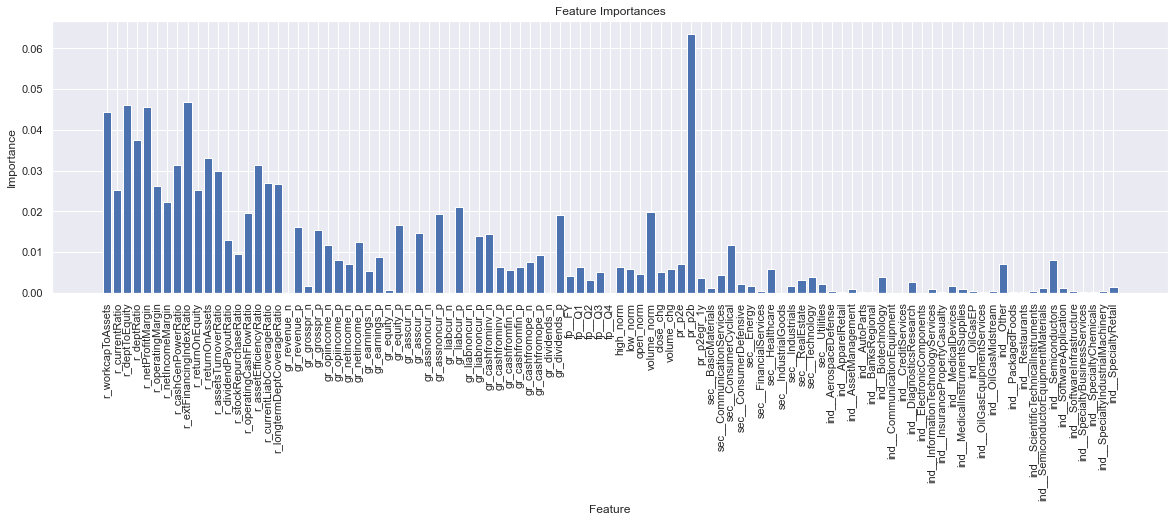

In [27]:
model = pipeline.stages[1]
importances = model.featureImportances
x_values = list(range(len(importances)))

f, ax = plt.subplots(figsize=(20,5))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

## 07_Create testdata and predict

In [18]:
testdata = df_joined.where(col('ticker').isin(top_500)) \
                 .where(filter_no_potential) \
                 .where(filter_date_from_2017)          
testdata.count()

424637

In [19]:
# we make sure that there are no null values
testdata = testdata.na.drop(how="any")
testdata.count()

424626

In [20]:
df_predicted = pipeline.transform(testdata)

In [21]:
# create pandas dataframe
df_predicted_pd_orig = df_predicted.drop('features').toPandas()
df_predicted_pd = df_predicted_pd_orig.copy()

## 08_Create DataFile for Robo Advisor

In [22]:
# only these columns are needed
robo_train_cls = ['ticker', 'Date', 'r_potential','r_short_term_potential','prediction', 'Close','High','Low', 'Open', 'close_norm']
robo_advisor_df = df_predicted_pd[robo_train_cls].copy()

In [23]:
robo_advisor_df['Date'] = pd.to_datetime(robo_advisor_df.Date)

# there are some duplicated entries
pred_mins = robo_advisor_df.groupby(['Date', 'ticker']).prediction.transform(min)
robo_advisor_df = robo_advisor_df.loc[robo_advisor_df.prediction == pred_mins]

# there are some dates who have only a few entries
date_counts = robo_advisor_df.Date.value_counts()
less = date_counts[date_counts < 400].index.tolist()
robo_advisor_df = robo_advisor_df[~robo_advisor_df.Date.isin(less)]

In [24]:
# not every company is traded on everyday. in order make the code easier, these gaps are filled
# we create a new dataframe that just contains date and ticker of the missing entries
trading_dates = set(robo_advisor_df.Date.to_list())
companies = robo_advisor_df.ticker.unique()

new_rows = []

for company in companies:
    dates_of_company = set(robo_advisor_df[robo_advisor_df.ticker == company].Date.tolist())
    diff = trading_dates - dates_of_company
    for date in diff:
        dict = {'Date':date, 'ticker':company}
        new_rows.append(dict)
new_entries_df = pd.DataFrame(new_rows)

In [25]:
# now we can merge the entries and use ffill() to copy the values from the prior existing trading day
pd_ra_data_df = pd.merge(robo_advisor_df, new_entries_df, how="outer", on=['Date','ticker'])
pd_ra_data_df.set_index('Date', inplace=True)
pd_ra_data_df.sort_index(inplace = True)
pd_ra_data_df[['r_potential', 'r_short_term_potential','prediction','Close','High','Low','Open','close_norm']] = pd_ra_data_df.groupby('ticker').transform(lambda v: v.ffill())

In [26]:
pd_ra_data_df.reset_index(inplace=True)

In [27]:
pd_ra_data_df.sort_values(['ticker','Date']).to_csv(trainingset_folder + "robo_train_set.csv", header=True, index=False)

## 09_Analysis

### Tools

In [34]:
# to be able to filter directly on the year, let's add a year column
df_predicted_pd['close_year'] = pd.DatetimeIndex(df_predicted_pd['Date']).year

In [18]:
def calc_rsme(df:pd.DataFrame):
    rmse = ((df.r_potential-df.prediction)**2).mean()**0.5
    return rmse

In [19]:
def draw_scatter(df_arr:List[pd.DataFrame], labels: List[str]):
    number = len(df_arr)
    fig, ax = plt.subplots(1, number, figsize=(number * 7,5))

    if number > 1:
        for i in range(number):
            ax[i].plot(df_arr[i].r_potential, df_arr[i].prediction,'b.')

            ax[i].set_title(labels[i])
            
            ax[i].set_ylim(-1,5)
            ax[i].set_xlim(-1,10)
            

            ax[i].set(xlabel='Potential', ylabel='Prediction')
    else:
            ax.plot(df_arr[0].r_potential, df_arr[0].prediction,'b.')

            ax.set_title(labels[0])

            ax.set_ylim(-1,5)
            ax.set_xlim(-1,10)
            
            ax.set(xlabel='Potential', ylabel='Prediction')

In [20]:
def create_groups(df:pd.DataFrame) -> List[pd.DataFrame]:
    pred_all =     df
    pred_min_10 =  df[df.prediction >  0.1]
    pred_min_30 =  df[df.prediction >  0.3]
    pred_min_50 =  df[df.prediction >  0.5]
    pred_min_75 =  df[df.prediction >  0.75]
    pred_min_100 = df[df.prediction >  1.0]
    pred_min_150 = df[df.prediction >  1.5]

    data_sets = [pred_all, pred_min_10, pred_min_30, pred_min_50, pred_min_75, pred_min_100, pred_min_150]
    return data_sets

group_labels = ['all', 'above 10%', 'above 30%','above 50%','above 75%','above 100%','above 150%']

In [21]:
def draw_box(list_df:List[pd.DataFrame]):
    data = [x.r_potential.tolist() for x in list_df]

    fig, ax = plt.subplots(figsize=(20,7))
    ax.boxplot(data, showmeans=True)
    ax.set_ylim(-1,3)
    plt.xticks(np.arange(len(group_labels))+1, group_labels)
    plt.show()

### Overall

In [39]:
df_predicted_pd=df_predicted_pd[df_predicted_pd.r_potential<15]

In [40]:
print("Overall Model Performance RMSE: %f" % calc_rsme(df_predicted_pd))

Overall Model Performance RMSE: 0.401875


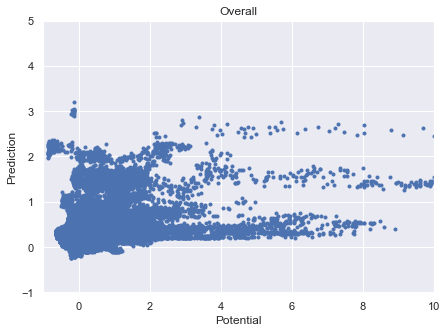

In [41]:
draw_scatter([df_predicted_pd],['Overall'])

### by Year Top 500

In [42]:
df_2017 = df_predicted_pd[(df_predicted_pd.close_year == 2017)]
df_2018 = df_predicted_pd[(df_predicted_pd.close_year == 2018)]
df_2019 = df_predicted_pd[(df_predicted_pd.close_year == 2019)]
df_2020 = df_predicted_pd[(df_predicted_pd.close_year == 2020)]

In [43]:
print("2017 Model Performance RMSE: %f" % calc_rsme(df_2017))
print("2018 Model Performance RMSE: %f" % calc_rsme(df_2018))
print("2019 Model Performance RMSE: %f" % calc_rsme(df_2019))
print("2020 Model Performance RMSE: %f" % calc_rsme(df_2020))

2017 Model Performance RMSE: 0.409375
2018 Model Performance RMSE: 0.316919
2019 Model Performance RMSE: 0.411977
2020 Model Performance RMSE: 0.524425


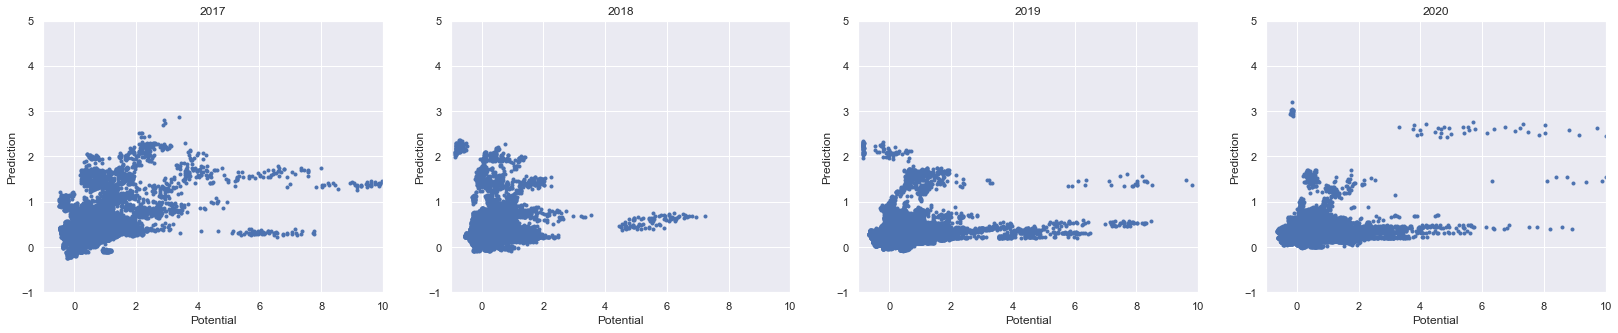

In [44]:
draw_scatter([df_2017, df_2018, df_2019,df_2020],['2017','2018','2019','2020'])

### Groups by year

In [52]:
groups_top500_all = create_groups(df_predicted_pd)
groups_top500_2017 = create_groups(df_2017)
groups_top500_2018 = create_groups(df_2018)
groups_top500_2019 = create_groups(df_2019)
groups_top500_2020 = create_groups(df_2020)

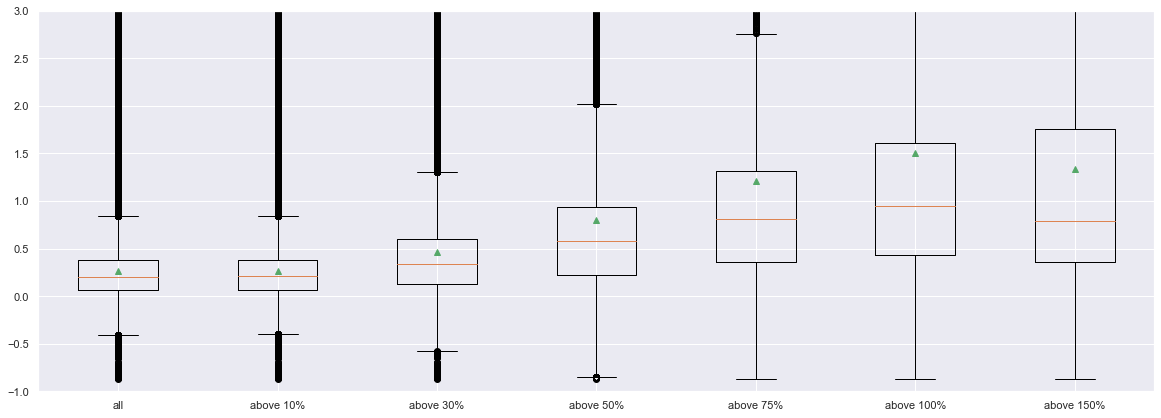

In [53]:
draw_box(groups_top500_all)

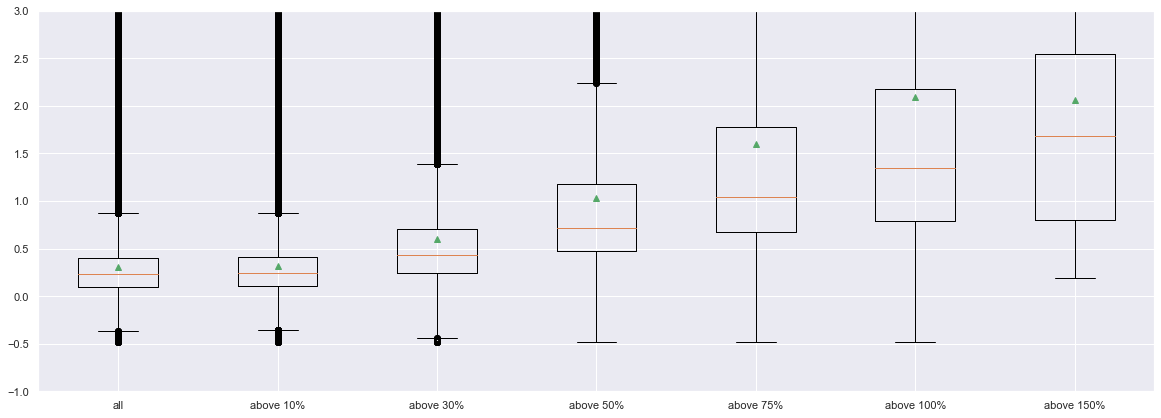

In [54]:
draw_box(groups_top500_2017)

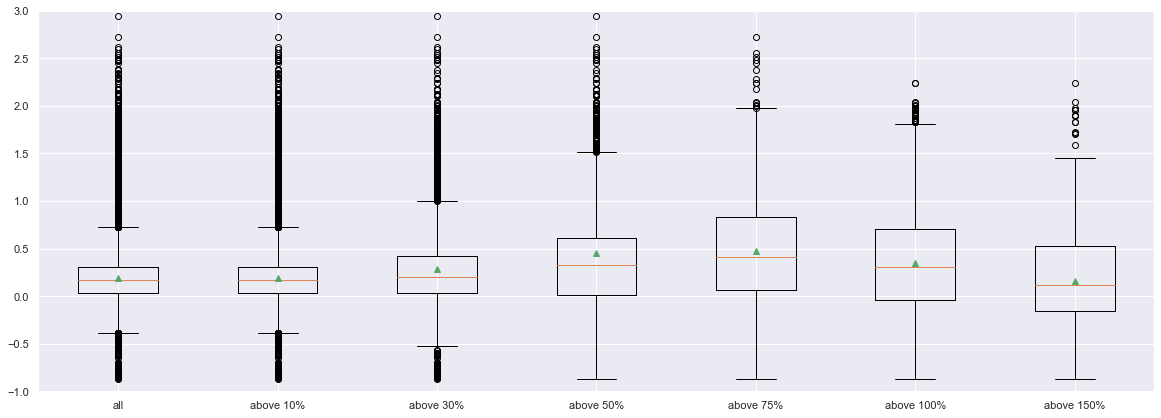

In [55]:
draw_box(groups_top500_2018)

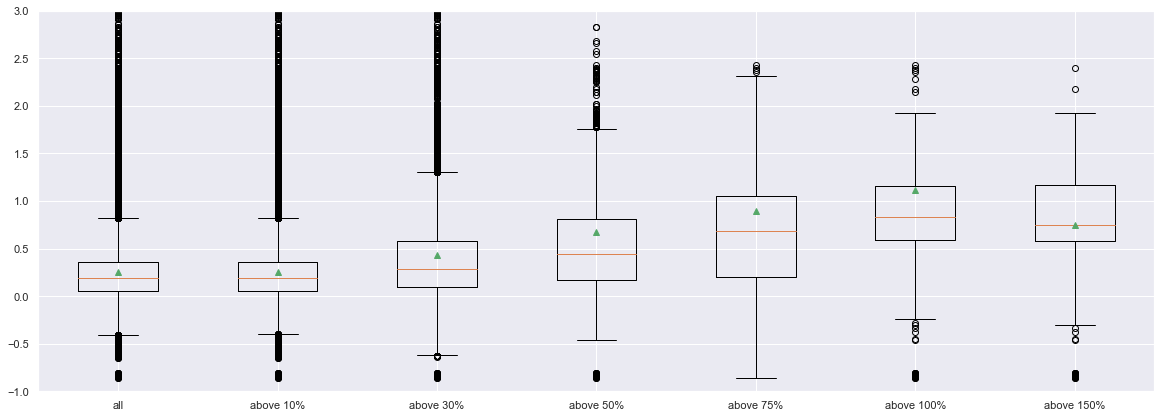

In [56]:
draw_box(groups_top500_2019)

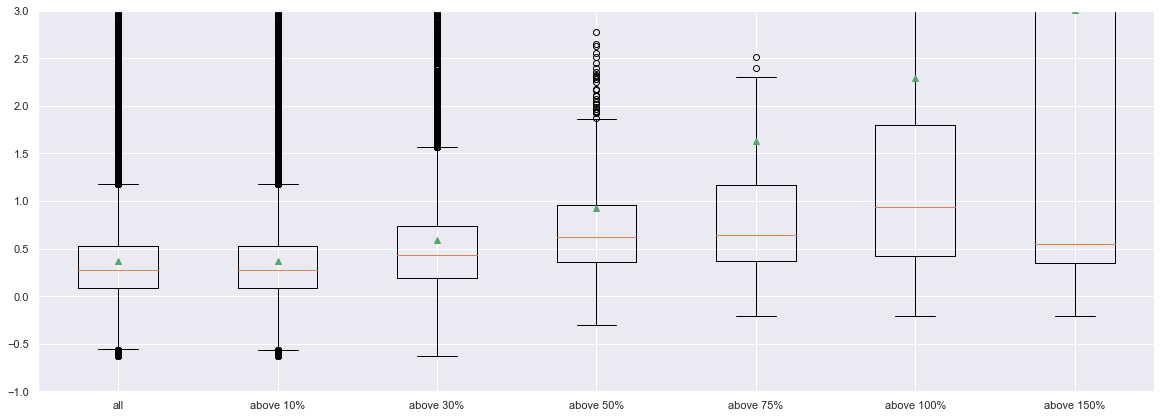

In [57]:
draw_box(groups_top500_2020)

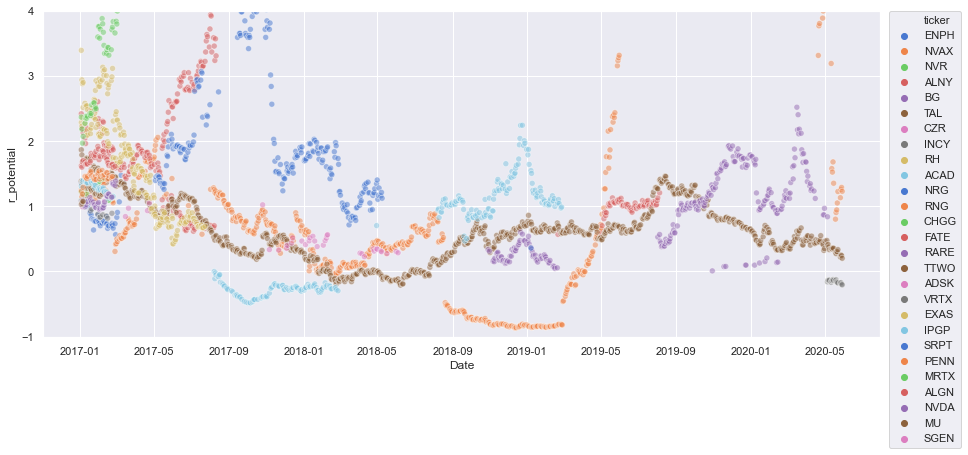

In [58]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(x="Date", y="r_potential", hue="ticker",  #size="prediction",
            sizes=(40, 400), alpha=.5, palette="muted",
            ax = ax, data= groups_top500_all[5])
ax.set_ylim(-1,4)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

## 99_stop spark

In [144]:
spark.stop()

## XX_Trials

In [44]:
df_train = df_joined.where(col('ticker').isin(top_500)) \
                      .where(filter_no_potential) \
                      .where(filter_date_before_2017) 

In [47]:
# define what the label column is
df_train = df_train.withColumn("label", col('r_potential'))

In [48]:
df_train = df_train.na.drop(how="any")
df_train.count()

570563

In [49]:
df_train_predicted = pipeline.transform(df_train)

In [50]:
# create pandas dataframe
df_train_predicted_orig = df_train_predicted.drop('features').toPandas()


In [63]:
df_train_predicted_pd['i_date'] = df_train_predicted_pd.Date
df_train_predicted_pd.set_index('i_date', inplace=True)

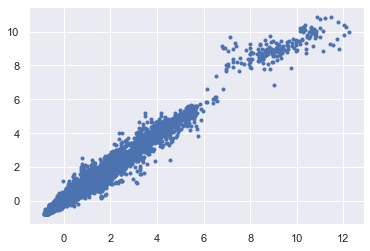

In [51]:
plt.plot(df_train_predicted_pd.r_potential, df_train_predicted_pd.prediction,'b.')

In [23]:
arr = np.arange(10)
diff = arr[1:] - arr[:-1]
print(arr)
print(diff)
for i in range(5, arr.shape[0]):
    print(np.sum(arr[i-4:i +1 ] - arr[i-5:i]) / 5)
arr[1:2]

[0 1 2 3 4 5 6 7 8 9]
[1 1 1 1 1 1 1 1 1]
1.0
1.0
1.0
1.0
1.0


array([1])

In [15]:
ROBO_ADVISOR_DATA_FILE = "D:/data_mt/09_training/robo_train_set.csv"

df = pd.read_csv(ROBO_ADVISOR_DATA_FILE, sep=',', encoding='utf-8', header=0)
df['Date'] = pd.to_datetime(df.Date)
df['day_of_week'] = df.Date.dt.dayofweek
df['mid_price'] = (df.High + df.Low) / 2

df['i_date'] = df.Date
df.set_index('i_date', inplace=True)
df.sort_index(inplace=True)

In [59]:
df_holder = pd.Series(df.index.unique().tolist()).to_frame()
df_holder.columns = ['Date']

df_holder = df_holder[df_holder.Date < "2017-01-12"].copy()

data = [
        {'ticker':'AAPL','shares':1, 'Date':pd.to_datetime("2017-01-03")},
        {'ticker':'AAPL','shares':5, 'Date':pd.to_datetime("2017-01-04")},
        {'ticker':'AAPL','shares':-4, 'Date':pd.to_datetime("2017-01-05")},
        {'ticker':'AAPL','shares':8, 'Date':pd.to_datetime("2017-01-06")},
        {'ticker':'MSFT','shares':6, 'Date':pd.to_datetime("2017-01-03")},
        {'ticker':'MSFT','shares':-3, 'Date':pd.to_datetime("2017-01-04")},
        {'ticker':'MSFT','shares':-3, 'Date':pd.to_datetime("2017-01-05")},
        {'ticker':'MSFT','shares':5, 'Date':pd.to_datetime("2017-01-06")},
]
df_data = pd.DataFrame(data)

In [22]:
# V1
df_holder.set_index('Date', inplace=True)
df_data.set_index('Date', inplace=True)
merged = df_holder.merge(df_data, left_index=True, right_index=True)
merged['cumsum'] = merged.groupby("ticker").value.cumsum()
merged

In [33]:
pd.merge(df_holder,df_data[df_data.ticker=='A'], how="outer", on="Date")

,Date,ticker,shares
0,2017-01-03,A,1.0
1,2017-01-04,A,5.0
2,2017-01-05,A,-4.0
3,2017-01-06,A,8.0
4,2017-01-09,NaN,NaN
5,2017-01-10,NaN,NaN
6,2017-01-11,NaN,NaN


In [60]:
tickers = ['AAPL','MSFT']
parts = []
for ticker in tickers:
    copy = df_holder.copy()
    copy['ticker'] = ticker
    parts.append(copy)
holder_all = pd.concat(parts)
combined = pd.merge(holder_all,df_data, how="left", on=['Date','ticker'])
combined.replace(np.NaN, 0, inplace=True)

In [63]:
closes = df[df.ticker.isin(tickers) & (df.Date <  "2017-01-12" )][['Date','ticker','Close']]

In [66]:
together = combined.merge(closes, on=['Date', 'ticker'])
together['i_date'] = together.Date
together.set_index('i_date', inplace=True)
together['sharesum'] = together.groupby("ticker").shares.cumsum()

In [67]:
together

,Date,ticker,shares,Close,sharesum
i_date,,,,,
2017-01-03,2017-01-03,AAPL,1.0,27.277639,1.0
2017-01-04,2017-01-04,AAPL,5.0,27.247108,6.0
2017-01-05,2017-01-05,AAPL,-4.0,27.385668,2.0
2017-01-06,2017-01-06,AAPL,8.0,27.690971,10.0
2017-01-09,2017-01-09,AAPL,0.0,27.944603,10.0
2017-01-10,2017-01-10,AAPL,0.0,27.972786,10.0
2017-01-11,2017-01-11,AAPL,0.0,28.123089,10.0
2017-01-03,2017-01-03,MSFT,6.0,58.673244,6.0
2017-01-04,2017-01-04,MSFT,-3.0,58.410725,3.0


In [15]:
aDate = pd.to_datetime('2017-01-04')
data_dict = df[df.ticker == 'AAPL'].loc[aDate].to_dict()
data_dict

{'Date': Timestamp('2017-01-04 00:00:00'),
 'ticker': 'AAPL',
 'r_potential': 0.5269239804857178,
 'prediction': 0.5207045366955093,
 'Close': 27.247108459472656,
 'High': 27.36218545657905,
 'Low': 27.183700184777077,
 'Open': 27.20718466459948,
 'close_norm': 0.2237404231613836,
 'day_of_week': 2,
 'mid_price': 27.27294282067806}

<AxesSubplot:>

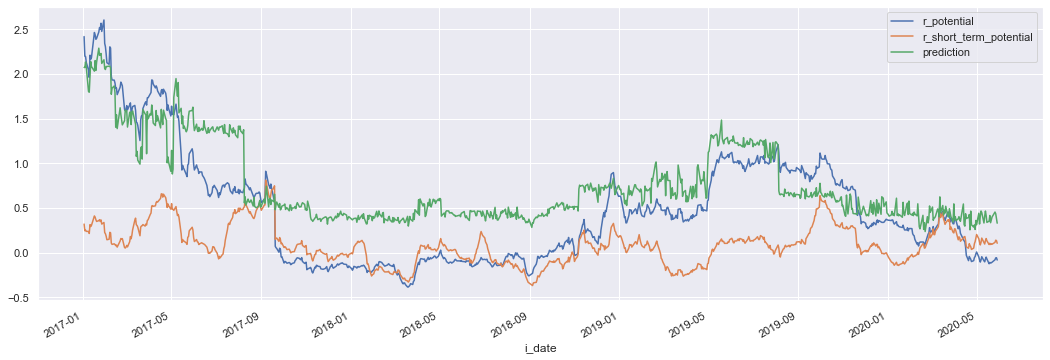

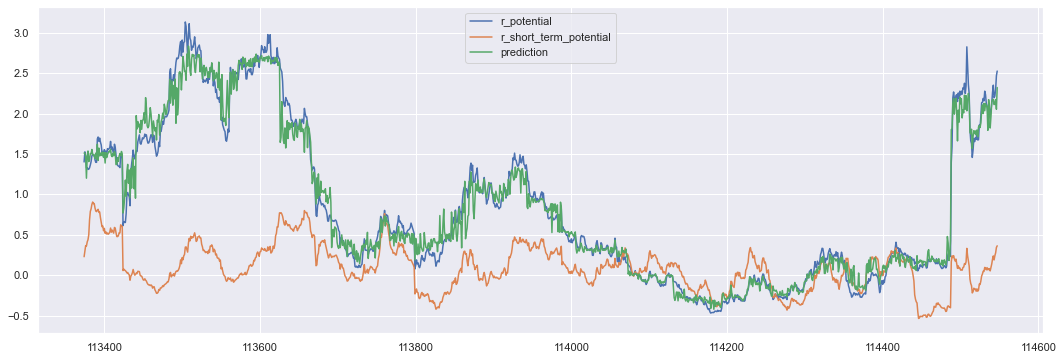

In [54]:
df.columns
df_alny = df[df.ticker=='ALNY']
df_train_alny = df_train_predicted_pd[df_train_predicted_pd.ticker=='ALNY']
df_alny[['r_potential', 'r_short_term_potential', 'prediction']].plot(figsize=(18,6))
df_train_alny[['r_potential', 'r_short_term_potential', 'prediction']].plot(figsize=(18,6))

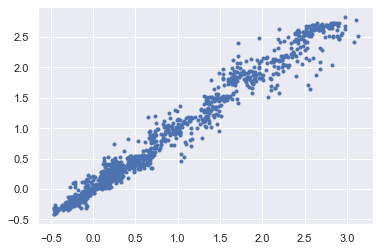

In [55]:
plt.plot(df_train_alny.r_potential, df_train_alny.prediction,'b.')

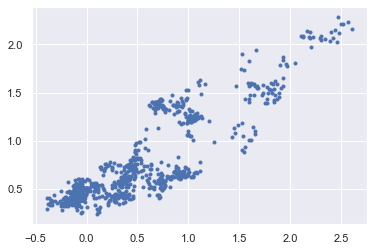

In [7]:
plt.plot(df_alny.r_potential, df_alny.prediction,'b.')

<AxesSubplot:xlabel='i_date'>

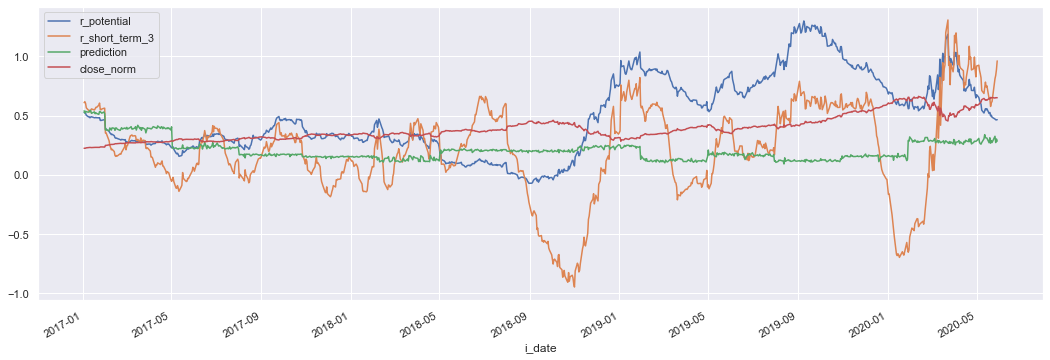

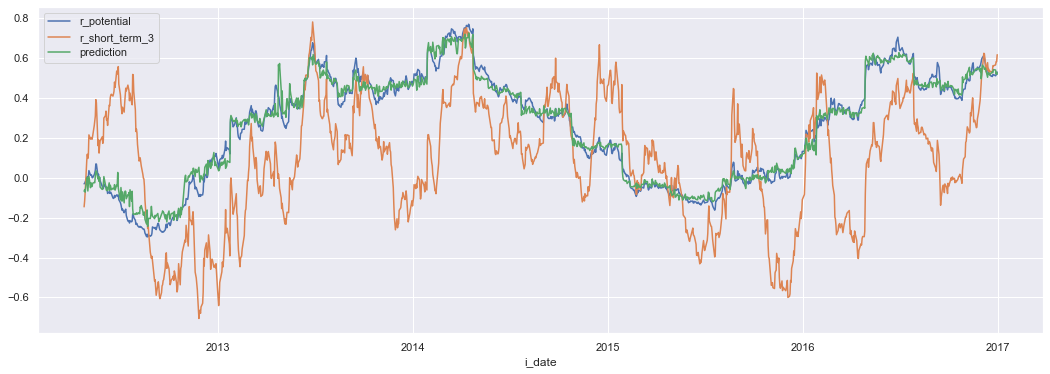

In [65]:
df_aapl = df[df.ticker=='AAPL'].copy()
df_aapl['r_short_term_3'] = df_aapl.r_short_term_potential * 3
df_aapl[['r_potential', 'r_short_term_3', 'prediction', 'close_norm']].plot(figsize=(18,6))
df_train_aapl = df_train_predicted_pd[df_train_predicted_pd.ticker=='AAPL'].copy()
df_train_aapl['r_short_term_3'] = df_train_aapl.r_short_term_potential * 3
df_train_aapl[['r_potential', 'r_short_term_3', 'prediction']].plot(figsize=(18,6))

<AxesSubplot:title={'center':'Testzeitraum'}, xlabel='i_date'>

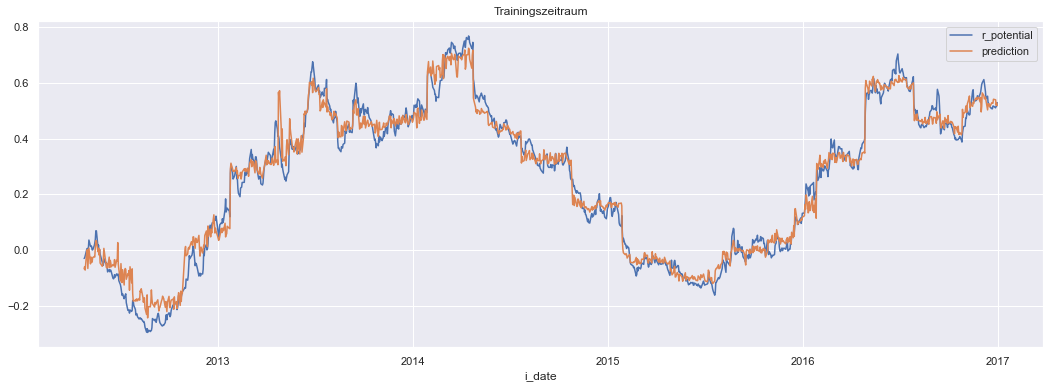

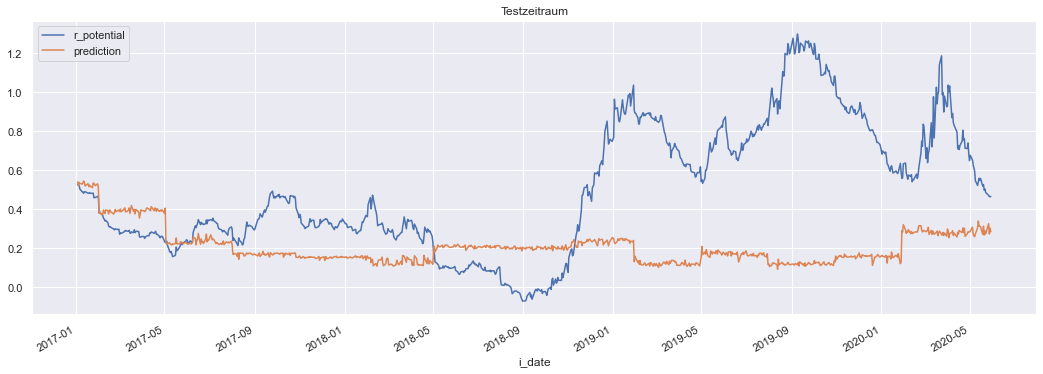

In [68]:
df_train_aapl[['r_potential', 'prediction']].plot(figsize=(18,6), title="Trainingszeitraum")
df_aapl[['r_potential', 'prediction']].plot(figsize=(18,6), title="Testzeitraum")

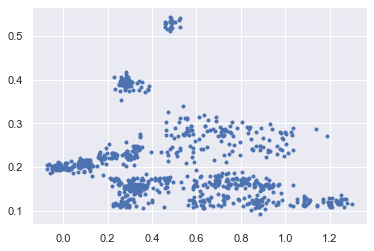

In [17]:
plt.plot(df_aapl.r_potential, df_aapl.prediction,'b.')

In [20]:
df_aapl.columns
df_aapl = df_aapl.iloc[df_aapl.index + 1]

TypeError: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [44]:
for group in df.groupby('ticker').groups:
    print(type(group))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [154]:
pd_ra_data_df.set_index('Date', inplace=True)
pd_ra_data_df.sort_index(inplace=True)

In [165]:
trading_days = pd.DataFrame(pd_ra_data_df.index.unique().tolist(), columns = ["Date"])
trading_days['weekday'] = trading_days.Date.dt.day_of_week

In [169]:
trading_days[240:260]

,Date,weekday
240,2017-12-14,3
241,2017-12-15,4
242,2017-12-18,0
243,2017-12-19,1
244,2017-12-20,2
245,2017-12-21,3
246,2017-12-22,4
247,2017-12-26,1
248,2017-12-27,2
249,2017-12-28,3


In [137]:
trading_days.head()

0   2017-01-02
1   2017-01-03
2   2017-01-04
3   2017-01-05
4   2017-01-06
dtype: datetime64[ns]